In [ ]:
!pip install torchsummary
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension



import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets
from torchvision.models import resnet50

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint
import pandas as pd



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 36.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/deepnote-config/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: problems found:
        - require?  X jupyter-js-widgets/extension
Paths used for configuration of notebook: 
    	/deepnote-config/jupyter/nbconfig/notebook.json


In [ ]:
#Here, I've loaded the data and converted them into PyTorch tensors
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        pixels = self.data_frame.iloc[idx, 1:].values.astype('float32')
        label = self.data_frame.iloc[idx, 0]
        image = pixels.reshape((28, 28))
        # image = pixels.reshape((1, 28, 28))

        if self.transform:
            image = self.transform(image)

        # image = torch.unsqueeze(image, 0)
        # print(image.shape)
        label = torch.tensor(label)

        return image, label


In [ ]:
transform2 = T.Compose([
    # T.Lambda(lambda x: numpy_horizontal_flip(x) if np.random.rand() < 0.5 else x),  # Randomly flip the image horizontally with a probability of 0.5
    T.Lambda(lambda x: random_resize_crop(x) if np.random.rand() < 0.5 else x),
    # T.RandomRotation(10),  # Randomly rotate the image by a maximum of 10 degrees
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]) 
])

def numpy_horizontal_flip(image):
    flipped_image = np.flip(image, axis=1).copy()
    return flipped_image

def random_resize_crop(image, scale_range=(0.8, 1.0), output_size=(28, 28)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    resized_image = np.round(image * scale_factor).astype(np.uint8)
    h, w = resized_image.shape
    target_h, target_w = output_size
    top = np.random.randint(0, h - target_h + 1)
    left = np.random.randint(0, w - target_w + 1)
    cropped_image = resized_image[top:top+target_h, left:left+target_w]
    return cropped_image

#no augmentations, just into a tensor and normalized.
transform = T.Compose([
    T.ToTensor(),  
    T.Normalize(mean=[0.5], std=[0.5]) 
])

train_set = CustomDataset('sign_mnist_train.csv', transform=transform2)
test_set = CustomDataset('sign_mnist_test.csv', transform=transform2)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

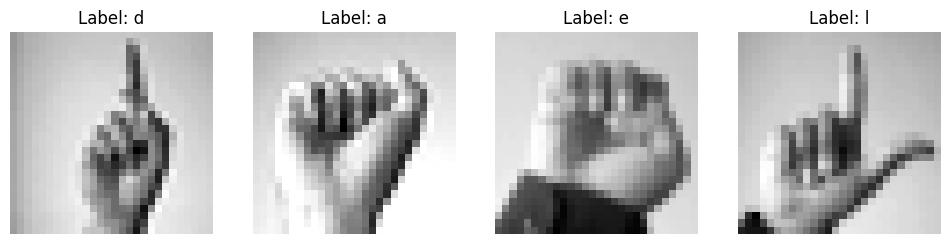

In [ ]:
data_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(data_loader))

def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for i, ax in enumerate(axes):
        image = images[i][0]  
        label = labels[i].item()
        image = image.numpy()
        image = np.squeeze(image)  
        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(chr(ord('a') + label)))
        ax.axis('off')
    plt.show()

show_images(images, labels)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, val_loader):
    total_correct = 0
    total_samples = 0
    USE_GPU = True
    dtype = torch.float32

    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    model = model.to(device=device)
    model.eval()

    with torch.no_grad():
        for inputs, labels in val_loader:       
            x = inputs.to(device=device, dtype=dtype)
            y = labels.to(device=device, dtype=torch.int64)
            scores = model(x)
            _, preds = scores.max(1)
            total_correct += (preds == y).sum().item()
            total_samples += labels.size(0)

    acc = total_correct / total_samples
    print(acc)
    return acc

In [ ]:
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    model = model.to(device=device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_batches = len(train_loader)

        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_loss = running_loss / total_batches
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f} | Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}')
    torch.save(model, 'model2.pt')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)  
        self.fc2 = nn.Linear(1024, 25) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

In [ ]:
num_epochs = 6
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)

In [ ]:
train(cnn, train_loader, test_loader, num_epochs, criterion, optimizer)

beginning to train model
0.8975050081952286
0.7693809258226436
Epoch [1/6], Loss: 1.7914 | Training Accuracy: 0.8975 | Validation Accuracy: 0.7694
0.9756328537606993
0.8515058561070831
Epoch [2/6], Loss: 0.1508 | Training Accuracy: 0.9756 | Validation Accuracy: 0.8515
0.9707157166272081
0.8319854991634132
Epoch [3/6], Loss: 0.0701 | Training Accuracy: 0.9707 | Validation Accuracy: 0.8320
0.9828446548898198
0.8604294478527608
Epoch [4/6], Loss: 0.0906 | Training Accuracy: 0.9828 | Validation Accuracy: 0.8604
0.986414132216354
0.848159509202454
Epoch [5/6], Loss: 0.0702 | Training Accuracy: 0.9864 | Validation Accuracy: 0.8482
0.9864869786924058
0.8839933073061907
Epoch [6/6], Loss: 0.0816 | Training Accuracy: 0.9865 | Validation Accuracy: 0.8840


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac6bbe3d-0e4c-42cf-a847-c5eb572ce48d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>